# Сортировка мусора
# Цель: 
Разработать модель для детеции пластиковых бутылок и других объектов на ленте конвейере
# Данные: 
- images - файл с 9000 изображениями, в них входят как тренировочные, так и тествоые изображения
- train.csv - файл с данными о названиях тренировочных изображений, о рамкамах объектов и класса объектов
- test.csv - файл с именами тестовых изображений
- sample_submission.csv - файл с примером сабмишина
# План:
- Изучение теории решения задач детекции
- Изучение данных
- Предобработка и исследовательский анализ данных
- Подбор модели и гиперпараметров

## Загрузка данных

In [3]:
import os
import csv
import gc
from ast import literal_eval
import shutil

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
WIDTH = 2048
HEIGHT = 1486
RANDOM_STATE = 42

In [5]:
train_csv = '/kaggle/input/waste-detection/train.csv'
train_root = '/kaggle/input/waste-detection/images'

df = pd.read_csv(train_csv)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32265 entries, 0 to 32264
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    32265 non-null  object 
 1   bbox         32148 non-null  object 
 2   category_id  32148 non-null  float64
dtypes: float64(1), object(2)
memory usage: 756.3+ KB


В датафрейме 3 столбца: file_name - названиея картинок, которые находятся в train_root, bbox- координаты боксов и category_id - класс объекта. В данных присутсвуют пропуски - изображения на которых нет объектов.

## Обработка и исследовательский анализ

       file_name                          bbox  category_id
2765  000856.jpg  [1006.0, 49.0, 286.0, 496.0]          1.0
2766  000856.jpg  [730.0, 158.0, 273.0, 506.0]          2.0
2767  000856.jpg  [986.0, 625.0, 229.0, 210.0]         13.0
2768  000856.jpg    [299.0, 0.0, 309.0, 191.0]          2.0


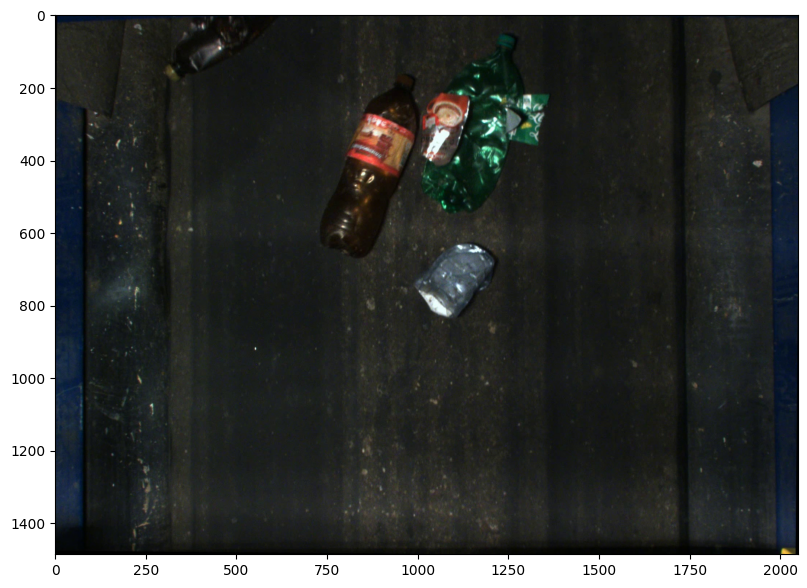

In [6]:
#Посмотрим на даныые
print(df[df['file_name'] == '000856.jpg'])

img_sample = mpimg.imread(os.path.join(train_root, '000856.jpg'))
plt.subplots(figsize=(10,7))
plt.imshow(img_sample)
plt.show()

Каждый объект на картинке имеет отдельную строку в df.

In [7]:
#Проверяем количество пропущенных значений
df.isna().sum()

file_name        0
bbox           117
category_id    117
dtype: int64

In [8]:
df[df['bbox'].isnull()].sample()

file_name bbox  category_id
5194  001930.jpg  NaN          NaN

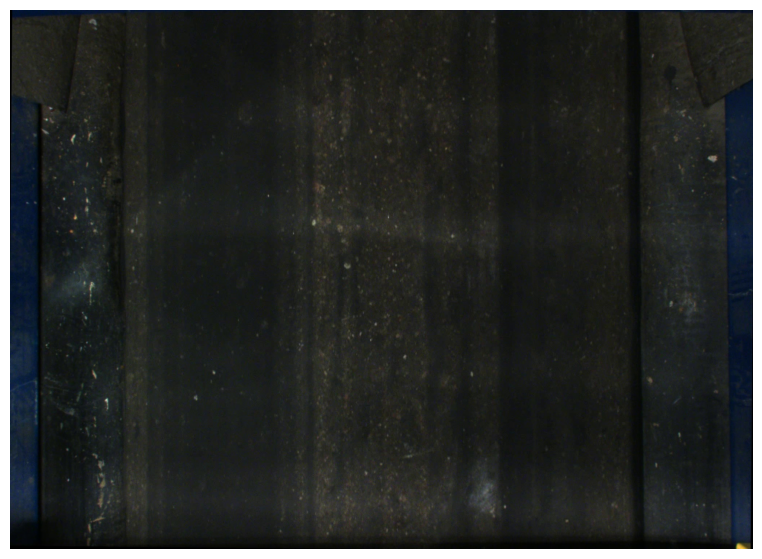

In [9]:
#Выведем картинку с пропущенными значениями в bbox и category_id
image_sample_nan = (os.path.join(train_root, '001914.jpg'))

img = mpimg.imread(image_sample_nan)
plt.subplots(figsize=(10,7))
plt.imshow(img)
plt.axis('off')
plt.show()

In [10]:
#Проверим распределение классов объектов
class_distribution = df['category_id'].value_counts()
class_distribution

category_id
2.0     7310
1.0     4747
13.0    4553
4.0     3780
7.0     2530
14.0    2278
10.0    2123
15.0    1032
5.0      909
3.0      848
9.0      653
6.0      495
11.0     374
8.0      364
12.0     152
Name: count, dtype: int64

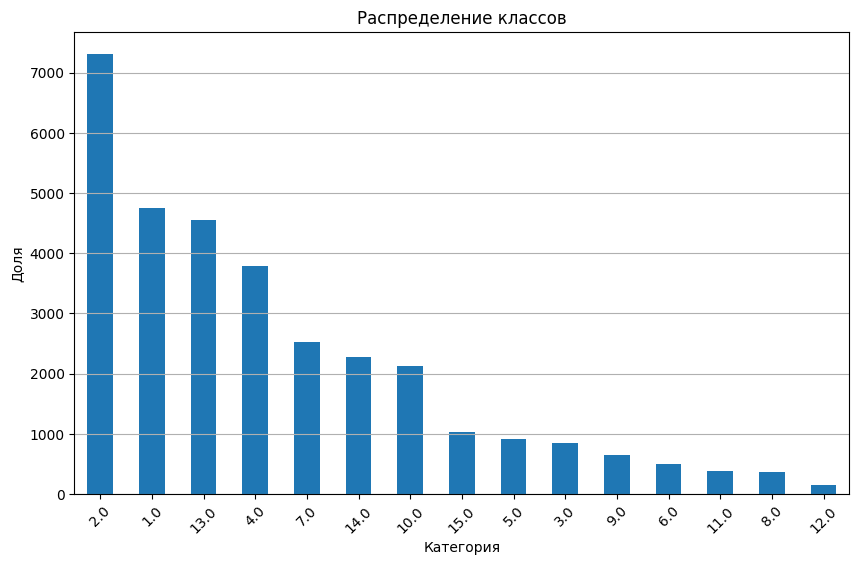

In [11]:
#Визуализируем распределение классов
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Категория')
plt.ylabel('Доля')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()

В данных наблюдается явный дисбаланс классов: встречается много объектов 2 и 1 категорий, мало - 12, 8 и 11

Была выдвинута гипотеза, что данные с пропущенными значениями в bbox и category_id важны для обучения модели, так как позволяют модели лучше понимать наличие объектов на изображении.

Аугментация данных должна помочь как с увеличением разнообразия данных, так и в борьбе с дисбалансом классов, т.к. можно аугментировать преимущественно классы с малым количеством примеров.

В качестве устранения дисбаланса классо можно также предложить:
- Ресемплирование
- Использование весов классов

Ресемплирование имеет несколько недостатков, при oversampling мы наполняем данными, которые не несут особой пользы, однако значительно поднимут затраты ресурсов на обучение моделей, при undersampling мы лишаем нас бльшого объема релевантных данных. 

In [12]:
#Удостоверяемся что все названия картинок что есть в датафрейме существуют в папке images
df_new = df[df['file_name'].apply(lambda x: os.path.exists(os.path.join(train_root, x)))]
df_new.shape

(32265, 3)

-----------------------------------------------------------------------------------------------------------------------

## Подготовка данных

In [13]:
# Создаем директории для данных
output_train_images = "/kaggle/working/yolo_data/train/images"
output_train_labels = "/kaggle/working/yolo_data/train/labels"
output_val_images = "/kaggle/working/yolo_data/val/images"
output_val_labels = "/kaggle/working/yolo_data/val/labels"
output_test_images = "/kaggle/working/yolo_data/test/images"

os.makedirs(output_train_images, exist_ok=True)
os.makedirs(output_train_labels, exist_ok=True)
os.makedirs(output_val_images, exist_ok=True)
os.makedirs(output_val_labels, exist_ok=True)
os.makedirs(output_test_images, exist_ok=True)


In [14]:
#Группируем данные по названиям изображений из-за того, что на одном изображении могут находится несколько объектов
grouped_df = df_new.groupby("file_name")
#Получаем список кортежей где каждому изображению соответсвуют его bbox и category_id
grouped_data = list(grouped_df)

#Перемешивание данных случайным образом
rng = np.random.default_rng(RANDOM_STATE)  
rng.shuffle(grouped_data)

#Разделение данных на тренировочные и валидационные 
train_frac = 0.9  
split_index = int(len(grouped_data) * train_frac)
train_groups = grouped_data[:split_index]
val_groups = grouped_data[split_index:]

#Возвращаем данные в датафреймы
train_df = pd.concat([group for _, group in train_groups], ignore_index=True)
val_df = pd.concat([group for _, group in val_groups], ignore_index=True)

In [15]:
def save_labels(df, images_output_path, labels_output_path):
    #Снова группируем по названию изображений
    grouped = df.groupby("file_name")  

    #Создаем аннотации для работы модели YoLo
    for file_name, group in grouped:
        #Путь к изображению
        image_path = os.path.join(train_root, file_name)
        #Путь к файлу аннотации для изображения
        label_path = os.path.join(labels_output_path, f"{os.path.splitext(file_name)[0]}.txt")
        
        if os.path.exists(image_path):
            #Cписок для хранения аннотаций для текущего изображения
            all_annotations = []
            try:
                #Перебираем данные в наших кортежах
                for _, row in group.iterrows():
                    # Учитываем наши изображения без объектов и просто пропускаем их
                    if pd.isna(row["bbox"]) or pd.isna(row["category_id"]):
                        continue

                    #Преобразование строки в список и извлечение параметров bbox
                    bbox = literal_eval(row["bbox"])
                    x, y, w, h = bbox

                    #Нормализация
                    x_center = (x + w / 2) / WIDTH
                    y_center = (y + h / 2) / HEIGHT
                    w_normalized = w / WIDTH
                    h_normalized = h / HEIGHT
                    
                    #Преобразуем номера классов, чтобы они начинались не с 1 а с 0, нужно для модели YoLo
                    category = row['category_id'] - 1

                    #Добавляем параметры bbox и класс объекта в список
                    all_annotations.append(f"{category} {x_center:.6f} {y_center:.6f} {w_normalized:.6f} {h_normalized:.6f}")
                
                #Запись аннотаций в файл
                with open(label_path, "w") as f:
                    f.write("\n".join(all_annotations)) 
                
                # Копирование изображений
                shutil.copy(image_path, images_output_path)
                
            except (ValueError, SyntaxError, KeyError) as e:
                print(f"Ошибка при парсинге рамок или отсутствуе данных: {file_name} ({e})")

In [16]:
#тренировочные данные
save_labels(train_df, output_train_images, output_train_labels)
#валидационные данные
save_labels(val_df, output_val_images, output_val_labels)

In [17]:
#Обработка тестовых данных
test_df = pd.read_csv("/kaggle/input/waste-detection/test.csv")
for _, row in test_df.iterrows():
    image_path = os.path.join(train_root, row["file_name"])
    if os.path.exists(image_path):
        shutil.copy(image_path, output_test_images)
    else:
        print(f"Skipping missing test image: {image_path}")

In [18]:
#Создание файла конфигурации в формате YAML для модели YoLo
data_yaml_path = '/kaggle/working/yolo_data/data.yaml'

data_yaml_content = f"""
train: /kaggle/working/yolo_data/train/images
val: /kaggle/working/yolo_data/val/images 
test: /kaggle/working/yolo_data/test/images

nc: 15 
names:
  0: PET (transparent) (green)
  1: PET (transparent) (brown)
  2: PET (transparent) (blue)
  3: PET (transparent)
  4: PET (transparent) (dark blue)
  5: PET (black)
  6: PET (white)
  7: PET (sticker)
  8: PET (flacon)
  9: PET (household chemicals)
  10: PND (household chemicals)
  11: PND packet
  12: Other plastic
  13: Other plastic (transparent)
  14: Not plastic
"""

#Запись в файл содержимое data_yaml_content, предварительно удаляя лишние пробелы и пустые строки
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content.strip())

## Обучение модели

In [19]:
model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 171MB/s]


In [20]:
model.train(data='/kaggle/working/yolo_data/data.yaml', epochs=120, imgsz=(1024,768));

Ultralytics 8.3.67 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/yolo_data/data.yaml, epochs=120, time=None, patience=100, batch=16, imgsz=(1024, 768), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

100%|██████████| 755k/755k [00:00<00:00, 45.8MB/s]
2025-01-26 08:21:23,972	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-26 08:21:24,698	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /kaggle/working/yolo_data/train/labels... 5400 images, 103 backgrounds, 0 corrupt: 100%|██████████| 5400/5400 [00:05<00:00, 1071.90it/s]


train: New cache created: /kaggle/working/yolo_data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/yolo_data/val/labels... 601 images, 14 backgrounds, 0 corrupt: 100%|██████████| 601/601 [00:00<00:00, 1068.64it/s]

val: New cache created: /kaggle/working/yolo_data/val/labels.cache



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      6.14G     0.8918      2.857      1.068         76       1024: 100%|██████████| 338/338 [02:46<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


                   all        601       3135       0.36      0.395      0.329      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      6.23G     0.8437      1.751      1.033         95       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.06it/s]

                   all        601       3135      0.567      0.506      0.496      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      6.14G     0.8621      1.539      1.044         69       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.08it/s]


                   all        601       3135      0.581      0.555      0.531      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      6.08G     0.8604      1.384      1.048         82       1024: 100%|██████████| 338/338 [02:43<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.09it/s]

                   all        601       3135      0.404      0.327      0.315      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      6.21G     0.8317      1.195      1.038         93       1024: 100%|██████████| 338/338 [02:40<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.23it/s]

                   all        601       3135        0.7      0.644      0.693      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      6.18G     0.8118      1.046      1.028         84       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]


                   all        601       3135      0.774       0.67      0.759      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      6.18G     0.7864     0.9397      1.018         83       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.33it/s]

                   all        601       3135      0.813      0.683      0.792      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120      6.12G     0.7729     0.8749      1.011         73       1024: 100%|██████████| 338/338 [02:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]

                   all        601       3135       0.86      0.762      0.861      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120       6.1G     0.7592      0.805      1.002         70       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.32it/s]

                   all        601       3135      0.912      0.782       0.87      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120       6.2G     0.7513     0.7793      1.001        100       1024: 100%|██████████| 338/338 [02:40<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.50it/s]

                   all        601       3135      0.879      0.782      0.881       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      6.17G       0.74      0.729      0.995         64       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]

                   all        601       3135      0.892      0.787      0.882      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      6.07G     0.7323     0.7109     0.9927         58       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.38it/s]

                   all        601       3135      0.891      0.801      0.885      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      6.21G     0.7196     0.6915     0.9865         92       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]

                   all        601       3135      0.926      0.817      0.909       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      6.26G     0.7156     0.6653     0.9847        108       1024: 100%|██████████| 338/338 [02:42<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]

                   all        601       3135      0.949      0.856      0.923      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120      6.08G     0.7084     0.6441      0.981         79       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]

                   all        601       3135      0.937      0.858      0.926      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      6.37G     0.7047     0.6341       0.98         56       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]

                   all        601       3135      0.951      0.865      0.927      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      6.28G     0.6933     0.6159     0.9777         78       1024: 100%|██████████| 338/338 [02:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.27it/s]

                   all        601       3135      0.957       0.87      0.927      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      6.21G     0.6869     0.5996      0.974         77       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]

                   all        601       3135      0.962      0.865      0.925      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      6.29G     0.6813     0.5969     0.9724         70       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]

                   all        601       3135      0.956      0.839      0.921      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      6.23G     0.6794     0.5839     0.9693         64       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.53it/s]

                   all        601       3135      0.943      0.885      0.934      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120       6.1G     0.6728      0.575     0.9688         53       1024: 100%|██████████| 338/338 [02:40<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.20it/s]

                   all        601       3135      0.972      0.873      0.938      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      6.09G     0.6661     0.5622     0.9687         82       1024: 100%|██████████| 338/338 [02:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.50it/s]

                   all        601       3135      0.949      0.865      0.935      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      6.26G     0.6677     0.5596     0.9646         65       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]

                   all        601       3135      0.958      0.888      0.938       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      6.12G     0.6617     0.5443     0.9625         66       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]

                   all        601       3135      0.955      0.886      0.939      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      6.12G     0.6552     0.5379     0.9605         83       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]

                   all        601       3135      0.939      0.907      0.947      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      6.15G     0.6497     0.5296     0.9579         74       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]

                   all        601       3135      0.968      0.882      0.945       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      6.02G     0.6446      0.522     0.9575         73       1024: 100%|██████████| 338/338 [02:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.50it/s]

                   all        601       3135       0.96      0.889      0.947      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120      6.13G     0.6386      0.518     0.9558         94       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.27it/s]

                   all        601       3135       0.97      0.886      0.947      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      6.21G     0.6365     0.5105     0.9553        108       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]

                   all        601       3135       0.98      0.881      0.944      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120       6.1G      0.634     0.5079     0.9538         79       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.51it/s]

                   all        601       3135      0.957      0.905      0.947      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      6.09G       0.63        0.5     0.9522         76       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]

                   all        601       3135       0.97      0.905      0.953      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120      6.13G     0.6287     0.4954     0.9534         68       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.36it/s]

                   all        601       3135      0.976      0.881      0.943      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120       6.1G     0.6267     0.4954     0.9544         60       1024: 100%|██████████| 338/338 [02:40<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.30it/s]

                   all        601       3135      0.972      0.897      0.947       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      6.07G     0.6255     0.4907     0.9514         85       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.50it/s]

                   all        601       3135      0.966      0.906       0.95      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      6.12G     0.6186     0.4851     0.9496         46       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.35it/s]

                   all        601       3135      0.971      0.902       0.95      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      6.06G     0.6186     0.4801     0.9495         71       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.38it/s]

                   all        601       3135      0.965      0.909      0.951      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      6.07G     0.6167     0.4773     0.9479         87       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]

                   all        601       3135      0.986      0.892      0.949      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120       6.2G     0.6085     0.4748      0.947         67       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]

                   all        601       3135      0.967        0.9       0.95      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      6.13G     0.6114     0.4689     0.9472         99       1024: 100%|██████████| 338/338 [02:46<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]

                   all        601       3135      0.973      0.915      0.956      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      6.21G     0.6077     0.4663     0.9466         87       1024: 100%|██████████| 338/338 [02:44<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]

                   all        601       3135      0.973      0.908      0.952      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      6.13G     0.6036     0.4629     0.9461         50       1024: 100%|██████████| 338/338 [02:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.19it/s]

                   all        601       3135      0.968      0.908      0.953      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      6.09G     0.5959     0.4531     0.9403         66       1024: 100%|██████████| 338/338 [02:44<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.37it/s]

                   all        601       3135      0.965      0.925      0.957      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      6.15G     0.5987     0.4536     0.9416         72       1024: 100%|██████████| 338/338 [02:42<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]

                   all        601       3135      0.984      0.911      0.956      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      6.23G     0.5941      0.447     0.9368         66       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.38it/s]

                   all        601       3135      0.974      0.909      0.953      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      6.13G     0.5895      0.446     0.9365         97       1024: 100%|██████████| 338/338 [02:44<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        601       3135      0.983      0.921      0.957       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120       6.2G      0.588     0.4441     0.9366         92       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]

                   all        601       3135      0.984      0.914      0.955       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      6.22G     0.5892     0.4438     0.9372         78       1024: 100%|██████████| 338/338 [02:44<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]

                   all        601       3135      0.982      0.907      0.954      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      6.23G     0.5838     0.4394      0.935         76       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]

                   all        601       3135      0.979      0.916      0.956      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      6.21G      0.579     0.4318     0.9325        101       1024: 100%|██████████| 338/338 [02:44<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.36it/s]

                   all        601       3135      0.985      0.914      0.959      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      6.09G     0.5788     0.4329     0.9333         86       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]

                   all        601       3135      0.974      0.914      0.957      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      6.13G     0.5776     0.4349     0.9353         65       1024: 100%|██████████| 338/338 [02:45<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.31it/s]

                   all        601       3135      0.979      0.919      0.959      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120       6.1G     0.5746     0.4296     0.9332        111       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.21it/s]

                   all        601       3135      0.982      0.917      0.958      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      6.09G     0.5764     0.4262     0.9298         68       1024: 100%|██████████| 338/338 [02:45<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]

                   all        601       3135       0.98       0.92      0.956      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      6.21G     0.5663     0.4223     0.9281         77       1024: 100%|██████████| 338/338 [02:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]

                   all        601       3135       0.98      0.921      0.959      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      6.12G     0.5675     0.4201     0.9296         72       1024: 100%|██████████| 338/338 [02:45<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.38it/s]

                   all        601       3135      0.984      0.925      0.961      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120      6.24G     0.5701     0.4205     0.9305         79       1024: 100%|██████████| 338/338 [02:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]

                   all        601       3135      0.983      0.924      0.959      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120      6.11G      0.566     0.4184     0.9292         85       1024: 100%|██████████| 338/338 [02:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]

                   all        601       3135      0.987      0.914      0.959      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      6.19G     0.5651     0.4139     0.9301         95       1024: 100%|██████████| 338/338 [02:43<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.28it/s]

                   all        601       3135      0.987      0.923       0.96      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      6.12G     0.5569      0.407     0.9251         81       1024: 100%|██████████| 338/338 [02:46<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.08it/s]

                   all        601       3135      0.982      0.921       0.96       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      6.12G     0.5548     0.4057     0.9251         75       1024: 100%|██████████| 338/338 [02:49<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]

                   all        601       3135      0.982      0.929      0.963      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      6.19G     0.5598     0.4094     0.9255         72       1024: 100%|██████████| 338/338 [02:46<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.49it/s]

                   all        601       3135      0.985      0.925       0.96      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      6.27G     0.5573     0.4052     0.9243         68       1024: 100%|██████████| 338/338 [02:45<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.32it/s]

                   all        601       3135      0.983      0.925      0.963      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      6.03G     0.5558     0.4028     0.9258         62       1024: 100%|██████████| 338/338 [02:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.36it/s]

                   all        601       3135      0.981      0.929      0.963      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      6.24G     0.5492     0.3986     0.9201         79       1024: 100%|██████████| 338/338 [02:47<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]

                   all        601       3135      0.976      0.929      0.962      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      6.06G     0.5494     0.4021     0.9191         97       1024: 100%|██████████| 338/338 [02:40<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        601       3135       0.98      0.924       0.96      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      6.07G     0.5448     0.3951     0.9196         53       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.49it/s]

                   all        601       3135      0.978      0.926      0.963      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120       6.2G     0.5478     0.3965     0.9245         54       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]

                   all        601       3135      0.972      0.932      0.961      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      6.11G     0.5444     0.3933     0.9223         80       1024: 100%|██████████| 338/338 [02:44<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]

                   all        601       3135      0.986       0.93      0.963      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      6.15G     0.5392      0.391     0.9184         99       1024: 100%|██████████| 338/338 [02:44<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.30it/s]

                   all        601       3135       0.98      0.932      0.963      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      6.12G     0.5415     0.3874     0.9203         66       1024: 100%|██████████| 338/338 [02:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]

                   all        601       3135      0.987      0.925      0.963      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      6.17G     0.5347     0.3833     0.9147         60       1024: 100%|██████████| 338/338 [02:46<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]

                   all        601       3135      0.989      0.927      0.963      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      6.37G     0.5334     0.3812     0.9138         57       1024: 100%|██████████| 338/338 [02:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.37it/s]

                   all        601       3135      0.988      0.929      0.964      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      6.13G     0.5352      0.381     0.9172         85       1024: 100%|██████████| 338/338 [02:46<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]

                   all        601       3135      0.971      0.935      0.964      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      6.09G     0.5267     0.3749     0.9124         83       1024: 100%|██████████| 338/338 [02:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]

                   all        601       3135      0.982      0.937      0.962       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120       6.1G     0.5307     0.3806     0.9176         75       1024: 100%|██████████| 338/338 [02:43<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        601       3135      0.986      0.932      0.963      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      6.06G      0.527     0.3764     0.9132         56       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.27it/s]

                   all        601       3135      0.986      0.928      0.963      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120      6.19G     0.5275     0.3718     0.9122         63       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]

                   all        601       3135      0.983      0.932      0.964       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      6.13G     0.5248     0.3725     0.9112         77       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]

                   all        601       3135      0.979      0.932      0.965      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      6.06G     0.5219     0.3673     0.9094         69       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]

                   all        601       3135      0.988       0.93      0.965      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120       6.3G     0.5193     0.3661     0.9067        108       1024: 100%|██████████| 338/338 [02:42<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]

                   all        601       3135      0.983      0.933      0.964      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      6.13G      0.515     0.3611     0.9075         60       1024: 100%|██████████| 338/338 [02:44<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]

                   all        601       3135      0.989      0.926      0.965      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      6.11G     0.5143     0.3624      0.908         71       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]

                   all        601       3135      0.989      0.931      0.965      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120      6.08G     0.5177     0.3652     0.9088         77       1024: 100%|██████████| 338/338 [02:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.31it/s]

                   all        601       3135      0.985      0.933      0.965      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      6.06G     0.5192     0.3646     0.9109         67       1024: 100%|██████████| 338/338 [02:43<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]

                   all        601       3135      0.987      0.934      0.966      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      6.09G     0.5153     0.3612      0.906         77       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]

                   all        601       3135      0.987      0.935      0.966      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      6.15G     0.5118     0.3594     0.9068        112       1024: 100%|██████████| 338/338 [02:46<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]

                   all        601       3135      0.987      0.933      0.965      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120       6.1G     0.5103     0.3565     0.9064         85       1024: 100%|██████████| 338/338 [02:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.32it/s]

                   all        601       3135      0.982      0.937      0.965      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      6.14G     0.5119     0.3545     0.9066         76       1024: 100%|██████████| 338/338 [02:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.49it/s]

                   all        601       3135      0.988      0.936      0.965      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      6.09G      0.505     0.3485     0.9043         39       1024: 100%|██████████| 338/338 [02:46<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.30it/s]

                   all        601       3135      0.986      0.938      0.966      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      6.12G     0.5037     0.3528     0.9015        104       1024: 100%|██████████| 338/338 [02:45<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.07it/s]

                   all        601       3135      0.985      0.935      0.966      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120      6.21G     0.5004     0.3513     0.9027         71       1024: 100%|██████████| 338/338 [02:44<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]

                   all        601       3135      0.985      0.935      0.965      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120      6.13G     0.5009     0.3466     0.9001         67       1024: 100%|██████████| 338/338 [02:48<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.32it/s]

                   all        601       3135      0.986      0.934      0.964      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      6.11G     0.4939     0.3425     0.8969        112       1024: 100%|██████████| 338/338 [02:47<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.49it/s]

                   all        601       3135      0.985      0.934      0.965      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120      6.37G     0.4945     0.3412     0.8985         78       1024: 100%|██████████| 338/338 [02:46<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]

                   all        601       3135      0.989      0.929      0.965      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      6.16G     0.4947     0.3413     0.8994         85       1024: 100%|██████████| 338/338 [02:45<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all        601       3135      0.987      0.935      0.965      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120       6.2G     0.4908     0.3371     0.8986         43       1024: 100%|██████████| 338/338 [02:41<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]

                   all        601       3135      0.987      0.935      0.965      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      6.17G     0.4909     0.3395     0.8947         60       1024: 100%|██████████| 338/338 [02:43<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]

                   all        601       3135      0.989      0.934      0.966      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120      6.12G     0.4897     0.3397     0.8969         94       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.35it/s]

                   all        601       3135      0.989      0.933      0.965      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      6.21G     0.4849     0.3369     0.8952         56       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]

                   all        601       3135      0.989      0.935      0.965      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120      6.14G     0.4892     0.3336     0.8964         42       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.37it/s]

                   all        601       3135       0.99      0.933      0.965      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120       6.1G      0.481     0.3312     0.8946         80       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]

                   all        601       3135      0.991      0.931      0.966      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      6.18G     0.4821      0.331     0.8921         76       1024: 100%|██████████| 338/338 [02:43<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

                   all        601       3135      0.985      0.934      0.965      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      6.07G      0.481     0.3278     0.8948         79       1024: 100%|██████████| 338/338 [02:43<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]

                   all        601       3135       0.99      0.931      0.965      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      6.11G     0.4764     0.3273     0.8923         89       1024: 100%|██████████| 338/338 [02:46<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.33it/s]

                   all        601       3135      0.983      0.939      0.965      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120       6.1G     0.4778     0.3268     0.8902         53       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.53it/s]

                   all        601       3135      0.984      0.941      0.966      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      6.06G     0.4727     0.3194     0.8858         60       1024: 100%|██████████| 338/338 [02:43<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.53it/s]

                   all        601       3135       0.98      0.943      0.966      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      6.49G     0.4705     0.3208     0.8873         74       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]

                   all        601       3135      0.988      0.939      0.966      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      6.38G     0.4682     0.3166     0.8871         67       1024: 100%|██████████| 338/338 [02:42<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.33it/s]

                   all        601       3135       0.99      0.939      0.966      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      6.36G     0.4713     0.3201     0.8887         65       1024: 100%|██████████| 338/338 [02:41<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.37it/s]

                   all        601       3135      0.986      0.942      0.966       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      6.23G     0.4661     0.3163     0.8878         60       1024: 100%|██████████| 338/338 [02:44<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]

                   all        601       3135      0.982      0.943      0.966       0.89


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120      5.95G     0.4135     0.2622     0.8531         44       1024: 100%|██████████| 338/338 [02:37<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]

                   all        601       3135      0.989      0.936      0.967      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      5.94G     0.4024     0.2522     0.8486         46       1024: 100%|██████████| 338/338 [02:33<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]

                   all        601       3135      0.989      0.936      0.967      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      5.93G     0.3978     0.2508     0.8464         58       1024: 100%|██████████| 338/338 [02:36<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.38it/s]

                   all        601       3135      0.991      0.936      0.967      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      5.94G     0.3968     0.2494     0.8494         47       1024: 100%|██████████| 338/338 [02:36<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.31it/s]

                   all        601       3135       0.99      0.938      0.967       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      5.89G     0.3893     0.2433     0.8449         39       1024: 100%|██████████| 338/338 [02:35<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.29it/s]

                   all        601       3135      0.989      0.935      0.967      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      5.92G     0.3892     0.2428     0.8433         40       1024: 100%|██████████| 338/338 [02:37<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.33it/s]

                   all        601       3135       0.99      0.937      0.967      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      5.95G     0.3858     0.2428     0.8425         46       1024: 100%|██████████| 338/338 [02:35<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]

                   all        601       3135       0.99      0.938      0.967      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      5.92G     0.3832      0.239     0.8401         41       1024: 100%|██████████| 338/338 [02:33<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]

                   all        601       3135      0.988      0.937      0.967       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      5.93G     0.3819     0.2375     0.8422         55       1024: 100%|██████████| 338/338 [02:34<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        601       3135       0.99      0.938      0.966       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      5.93G     0.3824     0.2374     0.8405         34       1024: 100%|██████████| 338/338 [02:35<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.54it/s]

                   all        601       3135       0.99      0.938      0.967       0.89



120 epochs completed in 5.732 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.67 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,585,077 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]


                   all        601       3135      0.989      0.935      0.967      0.892
PET (transparent) (green)        328        466      0.991       0.97      0.986      0.913
PET (transparent) (brown)        394        709      0.991      0.924      0.964      0.879
PET (transparent) (blue)         78         85      0.982      0.941      0.962      0.904
     PET (transparent)        282        377      0.992      0.912      0.963      0.866
PET (transparent) (dark blue)         90         99      0.989      0.873      0.938      0.856
           PET (black)         41         44      0.989      0.886      0.922      0.863
           PET (white)        211        261      0.992      0.904      0.958      0.899
         PET (sticker)         35         39          1      0.961      0.977      0.889
          PET (flacon)         45         48      0.978      0.923      0.964      0.894
PET (household chemicals)        168        200      0.993       0.92      0.966        0.9
PND

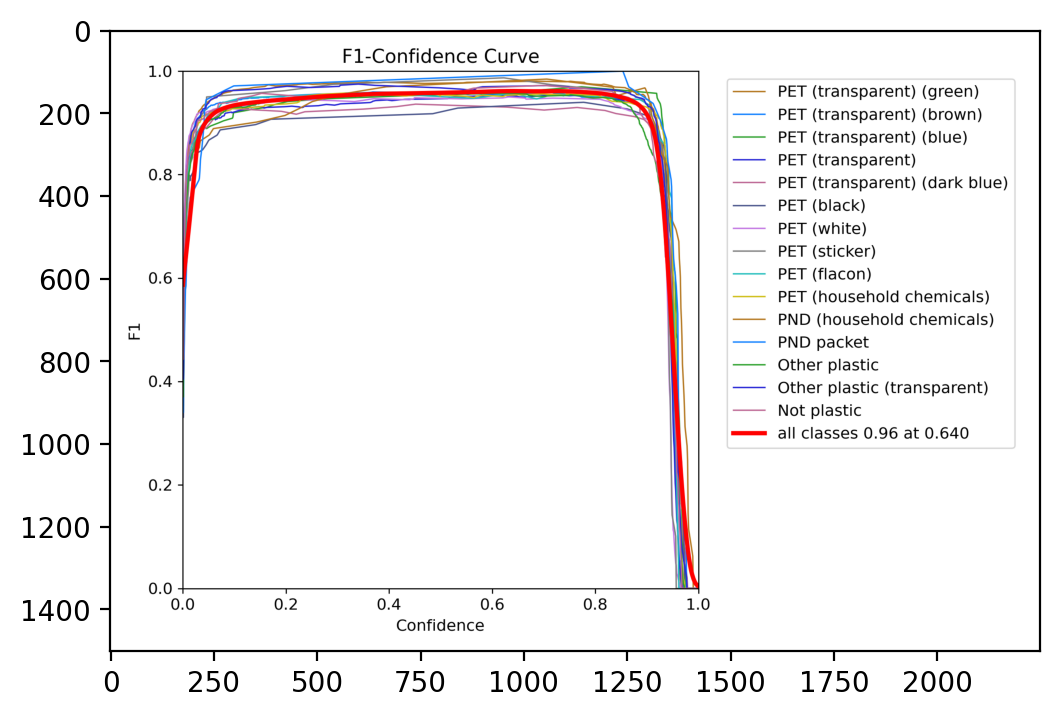

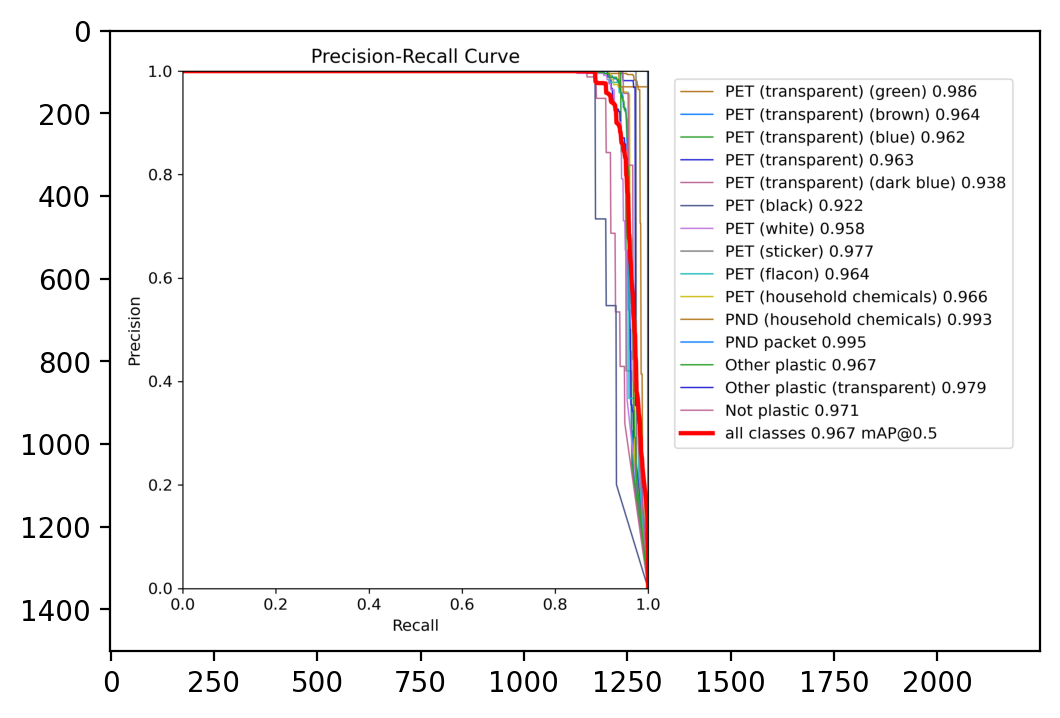

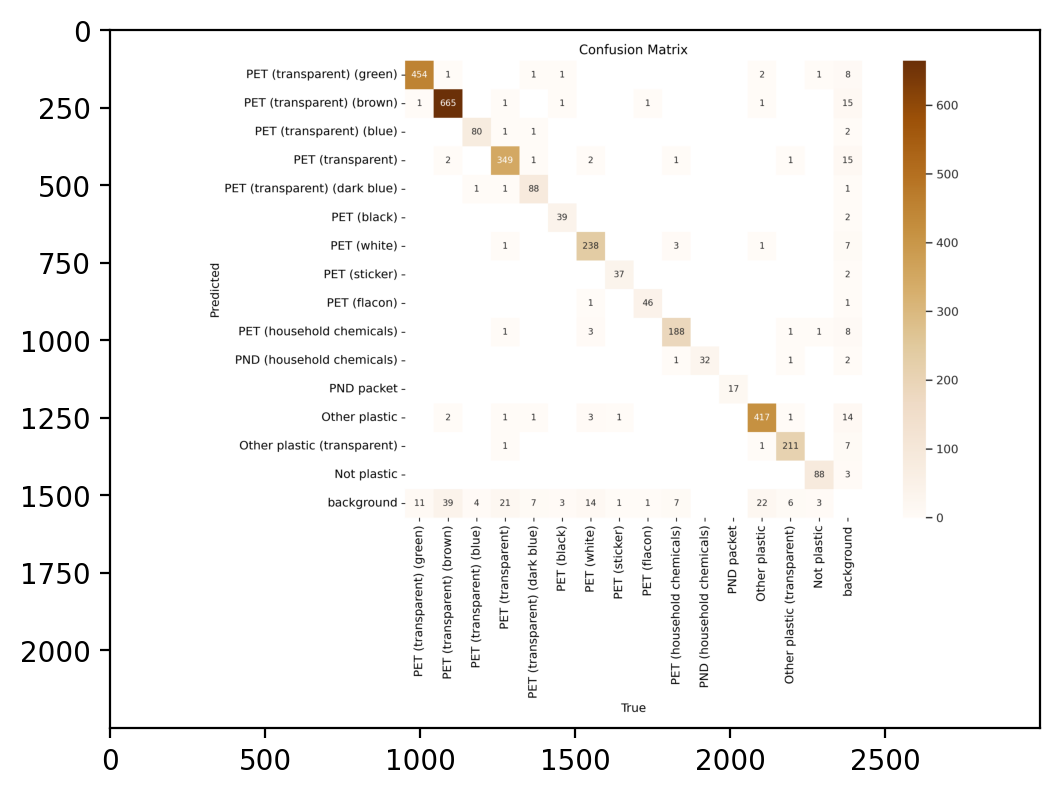

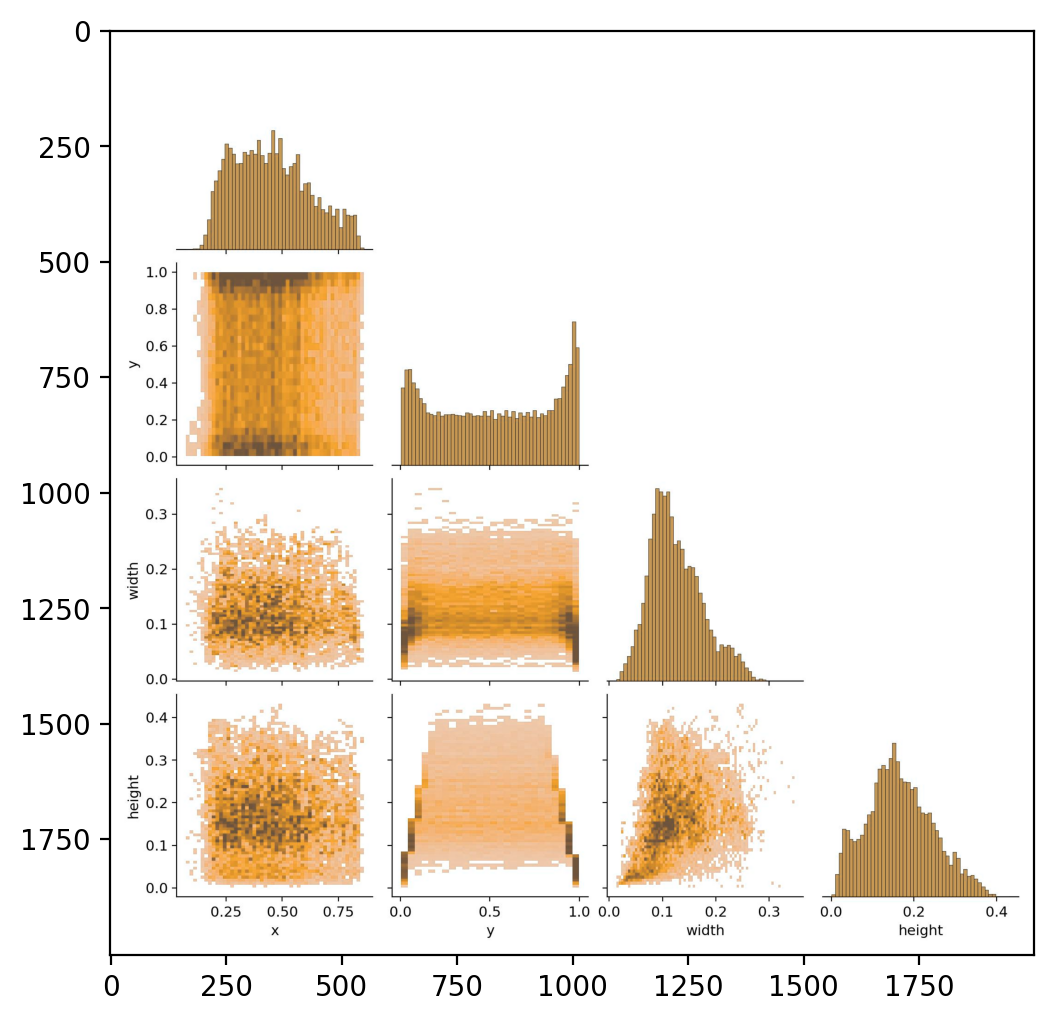

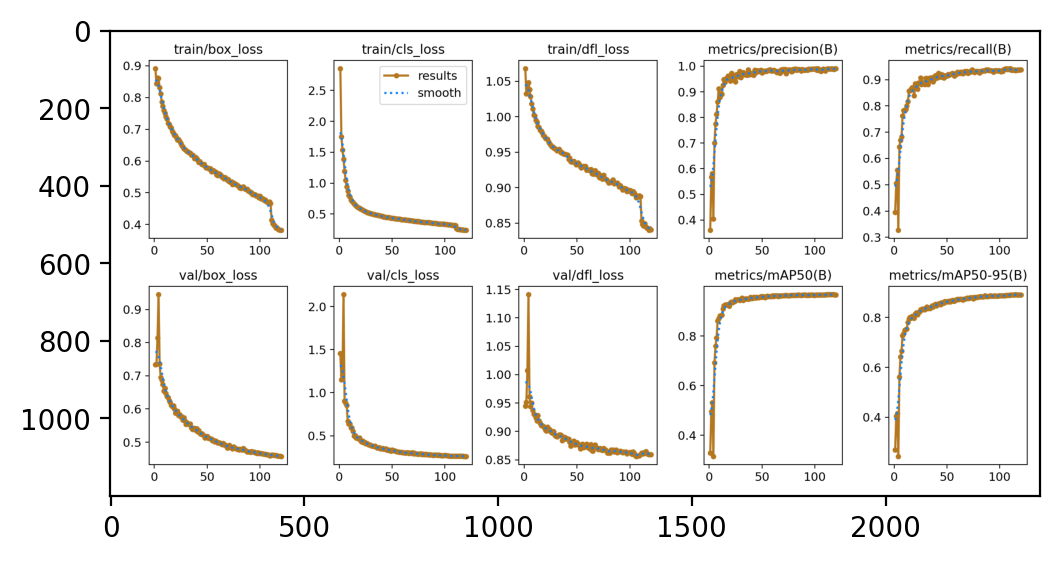

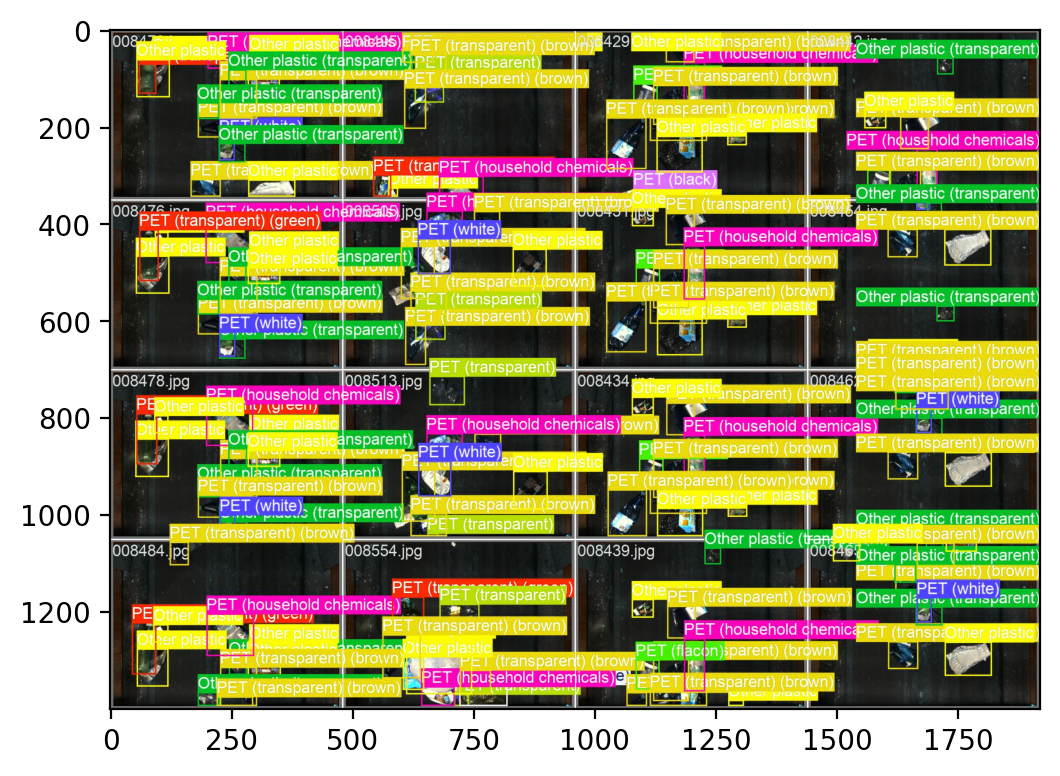

In [21]:
data_dir = '/kaggle/working/runs/detect/train'
img_lst = ['F1_curve.png', 'PR_curve.png', 'confusion_matrix.png', 'labels_correlogram.jpg', 'results.png', 'val_batch0_labels.jpg']

for image in img_lst:
    img_dir = os.path.join(data_dir, image)
    img = cv2.imread(img_dir)
    plt.figure(figsize=(6,6), dpi= 200)
    plt.imshow(img)

В процессе обучения были обучены различные архитектуры и модели задач детекции:

- Первой моделью стала Faster R-CNN, был содздан класс Dataset для загрузки и преобразования данных, к данным был применен Dataloader для разделения данных на батчи, обучение этой модели не привило ни к какому результату.
  
- Вследствие этого была выбрана другая архитектура - YoLo, для начала была взята модель YoLo8, после обучения на 30 эпохах модель показала неплохой результат на тесте weighted mean = 0.8146. Обучалась модель без 'пустых' изображений(т.е изобажения с пропусками в bbox и category_id не влючались в обучающую выборку). Далее в обучающую выборку были включены изображения без объектов, что повысило качество модели.
- В качестве основной модели была взяла YoLo11, были опробовано обучение с аугментацией и без нее, в результате чего было выявлено отсутствие больших различий в метрике, но в целях уменьшения затрат ресурсов было принято решение обучения без аугментации. Значительно улучшило метрику изменение входных размеров изображений от базовых 640 до (1024,768), вследстивии этого изменения и обучения модели на 120 эпохах была получена наилучшая метрика weighted mean = 0.873

## Предсказание на тесте

In [22]:
%%capture
#Загрузка весов лучшей модели
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

#Создание директории для предсказаний
output_path = '/kaggle/working/yolo_data/test/predictions'
os.makedirs(output_path, exist_ok=True)

test_images = [os.path.join(output_test_images, img) for img in os.listdir(output_test_images)]

#Подготовка CSV-файла для результатов
csv_file = '/kaggle/working/yolo_data/test/predictions/submission.csv'
csv_columns = ['file_name', 'bbox']


with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(csv_columns)
    
    #Обработка изображений по батчам, чтобы сэкономить паямть и ускорить процесс
    batch_size = 16
    for i in range(0, len(test_images), batch_size):
        batch = test_images[i:i + batch_size]
        
        #Предсказание
        results = model(batch)

        #Извлечение результатов 
        for j, result in enumerate(results):

            #Координаты центров, высота и ширина
            boxes = result.boxes.xywh.cpu().numpy()
            #Уверенность
            confs = result.boxes.conf.cpu().numpy()  
            #Класс
            classes = result.boxes.cls.cpu().numpy()
            
            #Извлечение имени текущего изображения
            img_name = os.path.basename(batch[j])
            #Список для параметров этого изображения
            file_bboxes = []
            
            
            for box, conf, cls in zip(boxes, confs, classes):
                #Меняем обратно номера классов, чтобы они соответсвовали изначальным
                cls += 1
                
                #Меняем формат праметров рамки на изначальный
                x_center, y_center, width, height = box
                x_left = (x_center - width / 2)
                y_top = (y_center - height / 2)
                
                #Создаем список и добавляем его в общий список для этого изображения, чтобы одной картинке соответстовала одна строка CSV-файла
                bbox = [cls, conf, x_left, y_top, width, height]
                file_bboxes.append(bbox)
            
            #Записываем в файл
            writer.writerow([img_name, file_bboxes])

        #Чистим память
        del results, boxes, confs, classes
        gc.collect()


0: 768x1024 2 PET (transparent) (green)s, 2 PET (transparent) (brown)s, 1 PET (transparent), 2 PET (white)s, 1 PET (flacon), 1 Other plastic (transparent), 8.5ms
1: 768x1024 1 PET (transparent) (green), 1 Other plastic (transparent), 1 Not plastic, 8.5ms
2: 768x1024 2 PET (transparent) (green)s, 3 PET (transparent) (brown)s, 2 PET (transparent)s, 1 PET (white), 1 PET (household chemicals), 1 Other plastic (transparent), 8.5ms
3: 768x1024 1 PET (transparent) (blue), 1 PET (transparent) (dark blue), 1 PET (white), 1 Other plastic (transparent), 8.5ms
4: 768x1024 1 PET (transparent) (green), 1 PET (transparent), 1 PET (transparent) (dark blue), 1 Other plastic, 8.5ms
5: 768x1024 1 PET (transparent) (green), 2 PET (transparent) (brown)s, 1 PET (transparent), 2 PET (white)s, 1 Other plastic, 1 Other plastic (transparent), 1 Not plastic, 8.5ms
6: 768x1024 1 PET (transparent) (green), 1 PET (transparent) (brown), 1 PET (transparent) (blue), 1 PET (transparent), 3 PET (household chemicals)s, 

## Заключение
В ходе соревнования была разработана модель, способная определять различные типы мусора на сортировочном конвейере мусороперерабатывающего завода.

Первый шаг - Изучение теории: история создания архитектур, решающих задачи детекции, типы архитектур и их принципы работы, метрика оценки качества модели.

Второй шаг - Загрузка данных: в ходе загрузки происходило первичное ознакомление с данными.

Третий шаг - Предобработка и исследовательский анализ: была изчуена структура данных, были выведены пример изображения и соответсвующих ему класса и параметров рамки, были обнаружены пропущенные значения в колонках, что означало отсутствие на изображение каких-либо объектов, в ходе процесса обучения и валидации результатов было принято решение оставить эти данные, так как они полезны для модели.

Четверый шаг - Подготовка данных: были созданы директории для данных, в которые были разделены тренировочные, валидационные и тестовые выборки. Далее был создан файла конфигурации в формате YAML для модели YoLo.

Пятый шаг - Обучение модели: в ходе работы были протестированы различные модели и их гиперпараметры. В результате лучшую метрику показала модель YoLo11 с imgsz=(1024,768) и обучением на 120 эпохах.

Шестой шаг - Тестирование: подготовка CSV-файла и предсказание на тестовых данных, в результате была получена метрика mAP=0.873